# Extracting Key Information about Child Labour from News Articles

This work has been submitted in partial fulfilment of the requirements of the Masters Degree in Urban Data Science and Analytics of the University of Leeds.  
- Date of submission: 23 April 2024
- Author: Subaru Shimizu

**Disclaimer:**  
- This work is for educational and informational purposes only. The author makes no warranties or representations about the accuracy, reliability, or completeness of the code.
- The author does not take any responsibility for any direct, indirect, incidental, or consequential damages and losses from the use of the work.
- The work is not to be reused, modified, or redistributed without explicit permission from the author.
- The results obtained from the analysis are not intended to criticise any specific country, region, or organization. Please note that further improvements in the methodology are necessary for more reliable outcomes.

**Overview:**  
  
This work aims to extract key information about child labour, such as countries and commodities, from the text of news articles. However, since the text files include website headers, footers, and advertisements, their readability is quite low. To overcome this challenge, we utilised the ChatGPT API, which excels at understanding the context of articles and filtering out irrelevant information.

# Step 0: Import Libraries

Import libraries.

In [24]:
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
palette = 'bwr' 
sns.set_palette(palette)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pd.options.mode.chained_assignment = None

from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo

from pysal.lib import weights
from pysal.lib import io

import contextily as cx 
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt

import folium
from folium import plugins

import spacy
import openai
import requests
from openai import OpenAI
from openai.types import Completion, CompletionChoice, CompletionUsage

from wordcloud import WordCloud
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
%matplotlib inline

Define the useful function.

In [ ]:
def extract_zip(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [ ]:
# Assign directory
directory = r'XXXXX'
 
# get all files under directory
file_list = os.listdir(directory)
 
# change the extention to .txt
for file_name in file_list:
    # file's full path
    file_path = os.path.join(directory, file_name)
    # change the exrtention
    new_file_path = os.path.splitext(file_path)[0] + '.txt'
    try:
        # change the file name
        os.rename(file_path, new_file_path)
        print(f"Renamed {file_path} to {new_file_path}")
    except Exception as e:
        print(f"Error renaming file {file_path}: {e}")

# Step 1: Preparation

### 1-1: Read Keywords of Child Labour and Commodities

We prepared a list of child labour related keywords with the help of ChatGPT in advance.  

In [ ]:
# Read the Excel file that summarises child labour related keywords.
keywords_excel = pd.read_excel('key_words.xlsx')
keywords_excel.head()

In [16]:
# Make a list of child labour keywords.
keyword_labour = []
for words in keywords_excel['Relevent to Child labour']:
    keyword_labour.append(words)

keyword_labour = [keyword for keyword in keyword_labour if pd.notnull(keyword)]
keywords = keyword_labour
keywords

['Child labour',
 'child labor',
 'kid worker',
 'Child Exploitation',
 'Underage Labour ',
 'Juvenile Labour',
 'Child Work',
 'Child Employment ',
 'Minor Labour',
 'Youth Labour',
 'Adolescent Labour',
 'Child Servitude',
 'Child Trafficking',
 'Child Servitude',
 'Underage Employment',
 'Child Exploitation',
 'Minor Workforce',
 'Youth Exploitation',
 'Child Trafficking',
 'Juvenile Exploitation',
 'Child Bondage',
 'Child Forced Labour',
 'Child Slavery',
 'Child Indentured Labour',
 'Child Sweatshop Labour',
 'Child Exploitative Labour',
 'Child Labor Trafficking',
 'Child Commercial Exploitation',
 'Child Abuse of Labour',
 'Child Employment Exploitation',
 'Child Labor Exploitation',
 'Child Labor Abuse',
 'Child Labor Trafficking',
 'Child Work Exploitation',
 'Child Work Abuse',
 'Child Labor Violation',
 'Child Workforce Exploitation',
 'Child Labor Malpractice',
 'Child Labor Infringement',
 'Child Workforce Injustice',
 'Child Labor Iniquity',
 'Child Labor Misuse',
 'Chil

In [17]:
# Make a list of commodity kewrods related to child labour.
commodity_labour = []
for words in keywords_excel['Relevent to commodies']:
    commodity_labour.append(words)
commodity_labour = [keyword for keyword in commodity_labour if pd.notnull(keyword)]
commodity_labour

['Gold',
 'Cobolt\xa0',
 'Textiles',
 'Apparel',
 'Footwear',
 'Toys',
 'Handicrafts',
 'Electronics',
 'Cosmetics',
 'Furniture',
 'Food processing products',
 'Ores',
 'Bricks',
 'Recycled materials',
 'Paper products',
 'Utensils',
 'Medical supplies',
 'Packaging materials',
 'Agricultural produce',
 'Metal products',
 'Building materials',
 'Leather goods',
 'Carpets',
 'Rugs',
 'Carpentry',
 'Garments',
 'Watches',
 'Jewelry',
 'Glassware',
 'Ceramics',
 'Pottery',
 'Tiles',
 'Plastics',
 'Paintings',
 'Sculptures',
 'Musical instruments',
 'Watches',
 'Eyewear',
 'Cosmetics',
 'Pharmaceuticals',
 'Automotive parts',
 'Sporting goods',
 'Fireworks',
 'Matches',
 'Cigarettes',
 'Handbags',
 'Wallets',
 'Stationery',
 'Carpentry tools',
 'Construction materials',
 'Cleaning products',
 'Agricultural chemicals',
 'Textile dyes',
 'Glues and adhesives',
 'Paints and coatings',
 'Batteries',
 'Electrical components',
 'Plastics and rubber products',
 'Carpets and rugs',
 'Furniture up

### 1-2: Read Text Files (News Articles) 

In [ ]:
def extract_text_file(file_path, encoding='utf-8'):
    with open(file_path, 'r', encoding=encoding) as file:
        text = file.read()
    return text

# Example usage
file_path = r'XXXXX'  
# Replace with the path to your text file
text_content = extract_text_file(file_path)
print(text_content)

### 1-3: Extract Text Files (News Articles) related to Child Labour

In [ ]:
## Find text files that contains the keywords.
def find_child_labor_references_in_folder(folder_path, keywords, max_files=10000, encoding='utf-8'):
    child_labor_files = []

    # Iterate over files in the folder
    file_count = 0
    for filename in os.listdir(folder_path):
        if file_count >= max_files:
            break

        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding=encoding, errors='ignore') as file:
                text = file.read().lower()  # Convert text to lowercase for case-insensitive matching

            # Check for keywords in the text
            for keyword in keywords:
                if keyword in text:
                    child_labor_files.append(filename)
                    break  # Once any keyword is found, no need to check further for this file

            file_count += 1

    return child_labor_files

folder_path = r'XXXXX'
child_labor_files = find_child_labor_references_in_folder(folder_path, keywords)

if child_labor_files:
    print("Files mentioning child labor keywords:", child_labor_files)
else:
    print("No files mentioning child labor keywords found.")

### 1-4: See the Extracted Text Files (News Articles) related to Child Labour

In [ ]:
# Open the child labour-related text files and show the contents
def process_files(file_paths, encoding='utf-8'):
    for file_path in file_paths:
        # Do something with each file
        print("Processing file:", file_path)
        with open(file_path, 'r', encoding=encoding, errors='ignore') as file:
            text = file.read()
            # Perform further processing or analysis on the file content
            # For example, you can print the content of the file
            print(text)
            print("-" * 50)  # Print a separator between files

# Call process_files with child_labor_folder list
process_files(child_labor_folder, encoding='utf-8')


In [ ]:
def read_text_files(file_paths):
    data = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            data.append(content)
    return data

# Assign a dataframe and accommodate contents.
def text_files_to_dataframe(file_paths):
    # Read text files
    texts = read_text_files(file_paths)
    # Create DataFrame
    df = pd.DataFrame({'Text': texts})
    # Optionally, add a column for file names
    df['File_Name'] = [os.path.basename(file_path) for file_path in file_paths]
    return df

# Create DataFrame
df = text_files_to_dataframe(child_labor_folder)

# Display DataFrame
print(df)

# Step3: Analysis using ChatGPT API

In [16]:
API_KEY=  "XXXXX"

### 3-1: Create Functions to Identify Key Information in Child Labour Related Articles

Function for Identifying Company Names

In [ ]:
def chat_gpt_companies(text, API_KEY):
    client = OpenAI(api_key = API_KEY)
    response = client.chat.completions.create(
        messages=[
    
            {
                "role": "system",
                "content": f"""Can you find the compaines that are mentioned in relation to child labour exploitation? 
                Here is the text:'{text}'. 
                Please provide a list of company names, without any additional text or sentences.
                If there are no relevant company names found, please return 'None'.
                Here is an example of your message: 'Microsoft, Alphabet'.
                """
            },
            {
                "role": "user",
                "content": text 
            }
            ],
            model = "gpt-3.5-turbo"
    )

    return (response.choices[0].message.content)

Function for Identifying Commodity Names

In [73]:
def chat_gpt_commodities(text, API_KEY):
    client = OpenAI(api_key = API_KEY)
    response = client.chat.completions.create(
        messages=[
    
            {
                "role": "system",
                "content": f"""Can you find the commodities that are mentioned in relation to child labour exploitation?
                Here is the text: '{text}'.
                Please provide a list of commodity names, without any additional text or sentences, using only the names in the commodity list: '{commodity_labour}'.
                If there are no relevant commodity names found, please return 'None'.
                Here is an example of your message: 'Jewelry, Apparel'.
                """
            },
            {
                "role": "user",
                "content": text 
            }
            ],
            model = "gpt-3.5-turbo"
    )
    return (response.choices[0].message.content)

Function for Identifying Country Names

In [74]:
## function to extract country info using chat gpt api 
def chat_gpt_countries(text, API_KEY):
    client = OpenAI(api_key = API_KEY)
    response = client.chat.completions.create(
        messages=[
    
            {
                "role": "system",
                "content": f"""Can you find the countries that are mentioned in relation to child labour exploitation?
                Here is the text: '{text}'.
                Please provide a list of country names, without any additional text or sentences.
                If there are no relevant country names found, please return 'None'.
                Here is an example of your message: 'United States, Indonesia'.
                """ 
            },
            {
                "role": "user",
                "content": text 
            }
            ],
            model = "gpt-3.5-turbo"
    )

    return (response.choices[0].message.content)

### 3-2: Extract the Key Information using ChatGPT API

Note: We attempted to extract company names mentioned in the articles. However, we found that some of the identified companies were not related to child labor exploitation and this approach has issue with the reliability. Therefore, we decided not to extract company names.

In [ ]:
# !CAUTION! Executing this cell consumes a lot of tokens.

output_df = pd.DataFrame(columns=['Companies', 'Commodities', 'Countries'])

start_index = 0
for index, row in df.iloc[start_index:].iterrows():
    text = row["Text"]
    try:
        output1 = chat_gpt_companies(text, API_KEY)
        output2 = chat_gpt_commodities(text, API_KEY)
        output3 = chat_gpt_countries(text, API_KEY)
        print("Index: {}, Companies: {} Commoditites: {} Countries: {}".format(index,output1,output2,output3))
        output_df.loc[index] = [output1,output2,output3]
    except Exception as e:
        print(f"Error processing text index: {index}.")
        continue
 
# Now output_df contains the combined outputs
print(output_df)

# Step5: Visualisation of Results

### 5-1: Countries Mentioned in Child Labour Related Articles

In [ ]:
output_df['Countries'] = output_df['Countries'].str.replace('.', '')
output_df

Responses from ChatGPT have variations in country names. It is necessary to unify country names if necessary.

In [ ]:
## DRC
output_df['Countries'] = output_df['Countries'].str.replace('Democratic Republic of Congo (DRC)', 'Democratic Republic of Congo')
output_df['Countries'] = output_df['Countries'].str.replace('Democratic Republic of the (DRC)', 'Democratic Republic of Congo')
output_df['Countries'] = output_df['Countries'].str.replace('Democratic Republic of the Congo', 'Democratic Republic of Congo')
output_df['Countries'] = output_df['Countries'].str.replace('DR Congo', 'Democratic Republic of Congo')

# Germany
output_df['Countries'] = output_df['Countries'].str.replace(' Germany', 'Germany')
# Nicaragua
output_df['Countries'] = output_df['Countries'].str.replace(' Nicaragua', 'Nicaragua')

# United States
output_df['Countries'] = output_df['Countries'].str.replace('America', 'United States')

# Brunei
output_df['Countries'] = output_df['Countries'].str.replace('Brunei', 'Brunei Darussalam')
output_df['Countries'] = output_df['Countries'].str.replace('and Brunei Darussalam', 'Brunei Darussalam')
output_df['Countries'] = output_df['Countries'].str.replace('Brunei Darussalam Darussalam', 'Brunei Darussalam')

# North Korea
output_df['Countries'] = output_df['Countries'].str.replace('North Korea', 'North Korea')

# United Kingdom
output_df['Countries'] = output_df['Countries'].str.replace('Britain', 'United Kingdom')
output_df['Countries'] = output_df['Countries'].str.replace('United Kingdom (UK)', 'United Kingdom')
output_df['Countries'] = output_df['Countries'].str.replace('the UK', 'United Kingdom')
output_df['Countries'] = output_df['Countries'].str.replace('UK', 'United Kingdom')

# Venezuela
output_df['Countries'] = output_df['Countries'].str.replace('Venezuela (Bolivarian Republic of)', 'Venezuela')

# Myanmar
output_df['Countries'] = output_df['Countries'].str.replace('Myanmar (Burma)', 'Myanmar')

# Russia
output_df['Countries'] = output_df['Countries'].str.replace('Russian Federation', 'Russia')

In [137]:
country_counts= {}
for data in output_df['Countries']:
    data = data.split(", ")
    for country in data:
        if country in country_counts:
            country_counts[country] += 1
        else:
            country_counts[country] = 1

In [ ]:
country_counts_df = pd.DataFrame(list(country_counts.items()), columns=['Country', 'Count'])
country_counts_df = country_counts_df.sort_values(by='Count', ascending=False)

# Remove "None"
country_counts_df = country_counts_df[country_counts_df['Country'] != 'None']
country_counts_df

In [143]:
# Extract Top20 countries
country_counts_df_top20 = country_counts_df[country_counts_df['Count']>=20]
country_counts_df_top20

,Country,Count
4,United States,243
13,India,97
6,China,86
45,Syria,64
3,Pakistan,63
21,Mexico,58
15,Bangladesh,54
19,Afghanistan,39
55,Ghana,39
52,Russia,39


In [144]:
fig = px.choropleth(country_counts_df_top20,
                     locations='Country',
                     locationmode='country names',
                     color='Count',
                     hover_name='Country',
                     color_continuous_scale='Reds',  
                     title='Frequencies of child exploitation news by country (over 20 counts only)')  
fig.update_layout(width=800, height=500)
fig.write_html("country_counts.html")
fig.show()

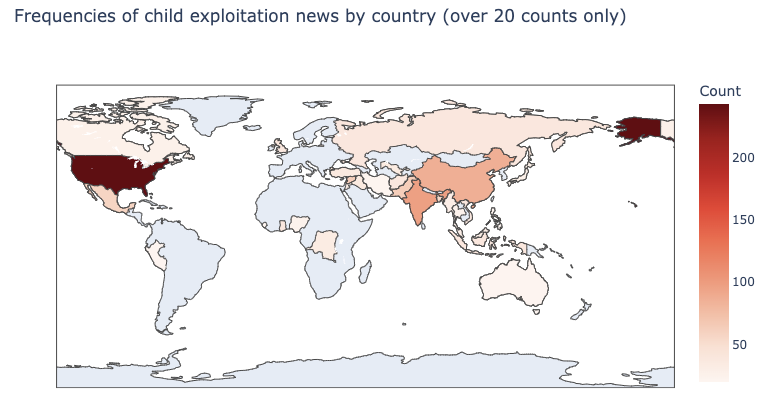

### 5-2: Commodities Mentioned in Child Labour Related Articles

In [ ]:
# Remove unnecessary punctuation marks.
output_df['Commodities'] = output_df['Commodities'].str.replace('\n-', ',')
output_df['Commodities'] = output_df['Commodities'].str.replace('[', '')
output_df['Commodities'] = output_df['Commodities'].str.replace(']', '')
output_df['Commodities'] = output_df['Commodities'].str.replace('.', '')
output_df['Commodities'] = output_df['Commodities'].str.replace("'", "")

# Unify commodity names
## Cobalt
output_df['Commodities'] = output_df['Commodities'].str.replace("cobolt", "cobalt")
## Apparel
output_df['Commodities'] = output_df['Commodities'].str.replace("cobolt", "cobalt")

In [202]:
commodity_counts= {}
for data in output_df['Commodities']:
    data = data.split(", ")
    for commodity in data:
        if commodity in commodity_counts:
            commodity_counts[commodity] += 1
        else:
            commodity_counts[commodity] = 1

In [ ]:
commodity_counts_df = pd.DataFrame(list(commodity_counts.items()), columns=['Commodity', 'Count'])
# Remove "None" and inappropriate words
commodity_counts_df = commodity_counts_df[~commodity_counts_df['Commodity'].isin(['None', 'Child labor','Child Labor'])]
# Reorganise
commodity_counts_df = commodity_counts_df.sort_values(by='Count', ascending=False)
commodity_counts_df.reset_index(drop=True)

In [207]:
# Extract Top20 Commodities.
commodity_counts_df_top20 = commodity_counts_df[:20]
commodity_counts_df_top20

,Commodity,Count
6,Apparel,115
7,Textiles,101
8,Garments,61
27,Footwear,57
41,Agricultural produce,45
21,Electronics,44
28,Handicrafts,43
20,Gold,43
18,Cotton,37
57,Toys,37


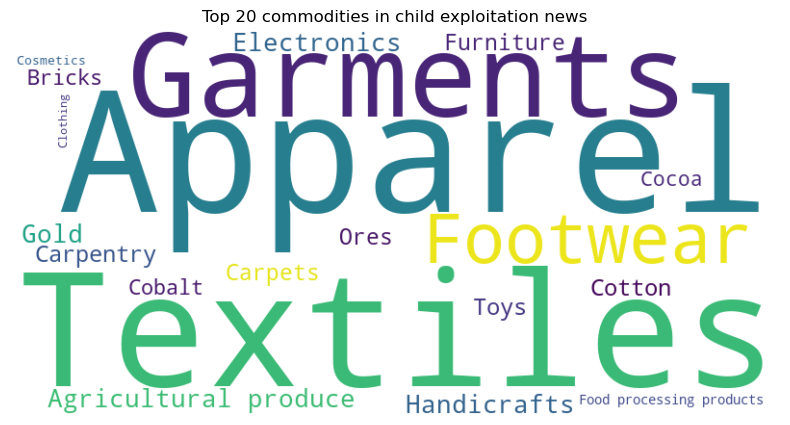

In [209]:
# Create a WordCloud
commodity_top20_freq = {commodity: count for commodity, count in zip(commodity_counts_df_top20['Commodity'], commodity_counts_df_top20['Count'])}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(commodity_top20_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 20 commodities in child exploitation news')

plt.savefig('wordcloud_commodity.jpeg', format='jpeg')
plt.show()
